# Ferdousi Gen


In [11]:
import os
import numpy as np
import matplotlib.pyplot as plt
import torch
from os import path

from torch.utils.data import Dataset, DataLoader, random_split
import torch.nn as nn
import torch.optim as optim

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(f"using {device} device")

using cuda device


In [12]:
class FerdousiDataset(Dataset):
    def __init__(self, root_dir):
        self.root_dir = root_dir
        self.data = self._load_data()
        
    def _load_data(self):
        with open(self.root_dir, 'r') as file:
            lines = file.readlines()
        
        # Remove metadata, split into beyts
        lines = [line.strip('\n') for line in lines]
        lines = lines[2:]
        lines = lines[0:2 * (len(lines) // 2)]
        
        data = {
            'stanza_1': lines[0::2],
            'stanza_2': lines[1::2],
            'len': len(lines) // 2,
        }
        
        return data

    def __getitem__(self, idx):
        if idx < len(self):
            return self.data['stanza_1'][idx], self.data['stanza_2'][idx]
        return None
    
    def __len__(self):
        return self.data['len']


In [13]:
base_path = '/kaggle/input/ferdousi-text/ferdousi.txt'
train_test_ratio = 0.9

dataset = FerdousiDataset(base_path)

num_samples = len(dataset)
train_size = int(train_test_ratio * num_samples)
test_size = num_samples - train_size
dataset_train, dataset_test = random_split(dataset, [train_size, test_size])

# Check the dataset sizes
print(f"Number of training examples: {len(dataset_train)}")
print(f"Number of test examples: {len(dataset_test)}")

print('Samples from dataset:')

for (stanza_1, stanza_2) in dataset:
    print(f'{stanza_1 = }')
    print(f'{stanza_2 = }')
    break

Number of training examples: 44647
Number of test examples: 4961
Samples from dataset:
stanza_1 = 'به نام خداوند جان و خرد'
stanza_2 = 'کزین برتر اندیشه برنگذرد'


In [23]:
# Load model directly
from transformers import AutoTokenizer, AutoModelForCausalLM, AutoConfig

model_name = "HooshvareLab/gpt2-fa"

special_tokens = {
    "bos_token": '[CLS]',
    "eos_token": '[SEP]',
    "unk_token": '[UNK]',
    "pad_token": '[PAD]',
}

opt = {
    **special_tokens,
    "padding_side": "left",
    "model_max_length": 16, # chosen by viewing the dataset
    "model_name": model_name,
}

tokenizer = AutoTokenizer.from_pretrained(model_name, **opt)

config = AutoConfig.from_pretrained(model_name, **tokenizer.special_tokens_map)

print(f'Vocab size: {len(tokenizer)}')


Vocab size: 42005


In [15]:
from tqdm import tqdm

class TokenizedFerdousiDataset(Dataset):
    def __init__(self, ferdousiDataset, tokenizer):
        self.tokenizer = tokenizer
        self.ferdousiDataset = ferdousiDataset
        
        self.encodings = {
            'input_ids': [],
            'labels': [],
            'attention_mask': [],
        }
        
        for (stanza_1, stanza_2) in tqdm(ferdousiDataset, desc='Tokenizing'):
            input_enc = tokenizer(
                tokenizer.bos_token + stanza_1 + tokenizer.eos_token,
                truncation=True,
                padding="max_length"
            )

            target_enc = tokenizer(
                tokenizer.bos_token + stanza_2 + tokenizer.eos_token,
                truncation=True,
                padding="max_length"
            )
            
            self.encodings['input_ids'].append(torch.tensor(input_enc['input_ids']))
            self.encodings['labels'].append(torch.tensor(target_enc['input_ids']))
            self.encodings['attention_mask'].append(torch.tensor(input_enc['attention_mask']))

    def __getitem__(self, idx):
        return {
            'input_ids': self.encodings['input_ids'][idx],
            'labels': self.encodings['labels'][idx],
            'attention_mask': self.encodings['attention_mask'][idx],
        }

    def __len__(self):
        return len(self.ferdousiDataset)


In [16]:
tokenized_dataset_train = TokenizedFerdousiDataset(dataset_train, tokenizer)
tokenized_dataset_test = TokenizedFerdousiDataset(dataset_test, tokenizer)

batch_size = 128

train_dataloader = DataLoader(
    tokenized_dataset_train,
    batch_size=batch_size,
    shuffle=True,
    num_workers=os.cpu_count(),
    pin_memory=False
)
test_dataloader = DataLoader(
    tokenized_dataset_test,
    batch_size=batch_size,
    shuffle=True,
    num_workers=os.cpu_count(),
    pin_memory=False
)

if os.cpu_count() > 1:
    os.environ["TOKENIZERS_PARALLELISM"] = "true"

print('Samples from dataloader:')
for encoding in train_dataloader:
    input_ids = encoding['input_ids']
    target_ids = encoding['labels']
    print(f'{input_ids[0].shape = }')
    input_stanza_original = tokenizer.decode(input_ids[0])
    print(f'{input_stanza_original = }')
    input_stanza_clean = tokenizer.decode(input_ids[0], skip_special_tokens=True)
    target_stanza_clean = tokenizer.decode(target_ids[0], skip_special_tokens=True)
    print(f'{input_stanza_clean = }')
    print(f'{target_stanza_clean = }')
    poem = input_stanza_clean + ' , ' + target_stanza_clean
    print(f'{poem = }')
    break

Tokenizing: 100%|██████████| 4961/4961 [00:01<00:00, 3744.61it/s]


Samples from dataloader:
input_ids[0].shape = torch.Size([16])
input_stanza_original = '[CLS]خداوند پیروزی و فرهی[SEP][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD]'
input_stanza_clean = 'خداوند پیروزی و فرهی'
target_stanza_clean = 'خداوند دیهیم و شاهنشهی'
poem = 'خداوند پیروزی و فرهی , خداوند دیهیم و شاهنشهی'


In [17]:
model = AutoModelForCausalLM.from_config(config)

model.resize_token_embeddings(len(tokenizer))
model = model.to(device)

parallel = torch.cuda.device_count() > 1

if parallel:
    model = nn.DataParallel(model)

optimizer = optim.Adam(model.parameters(), lr=5e-4)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.9)

model

GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(42005, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-11): 12 x GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D()
          (c_proj): Conv1D()
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=768, out_features=42005, bias=False)
)

In [18]:
model.train()

for encoding in train_dataloader:
    encoding = {k:v.to(device) for k, v in encoding.items()}
    encoding.pop('labels')
    encoding['attention_mask'] = torch.ones_like(encoding['attention_mask']).to(device)
    gen = model.module if parallel else model
    outputs = gen.generate(
        **encoding,
        top_k=50,
        max_length=25,
        num_beams=5,
        no_repeat_ngram_size=2,
        num_return_sequences=1,
        pad_token_id=tokenizer.eos_token_id
    )
    in_stanza = tokenizer.decode(encoding['input_ids'][0], skip_special_tokens=True)
    out_stanza = tokenizer.decode(outputs[0])
    print('Input sequence: ')
    print(in_stanza)
    print('Output sequence: ')
    print(out_stanza)
    break

Input sequence: 
جهاندار نپسندد از ما ستم
Output sequence: 
[CLS]جهاندار نپسندد از ما ستم[SEP][PAD][PAD][PAD][PAD][PAD][PAD][PAD] ملامت ضدالتهاب s sirdird فرانشیز فرانشیز ملامت


In [19]:
num_epochs = 16
loss_dict = {'train_losses': [], 'val_losses': []}

for epoch in range(num_epochs):
    model.train()
    total_train_loss = 0

    for encoding in tqdm(train_dataloader, desc=f"Training loop {epoch+1}/{num_epochs}"):
        encoding = {k:v.to(device) for k, v in encoding.items()}
        encoding['attention_mask'] = torch.ones_like(encoding['attention_mask']).to(device)
        outputs = model(**encoding, token_type_ids=None)
        loss = outputs.loss
        total_train_loss += loss.item()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    avg_train_loss = total_train_loss / len(train_dataloader)
    loss_dict['train_losses'].append(avg_train_loss)

    model.eval()
    total_val_loss = 0

    with torch.no_grad():
        for val_encoding in tqdm(test_dataloader, desc=f"Validation loop {epoch+1}/{num_epochs}"):
            val_encoding = {k: v.to(device) for k, v in val_encoding.items()}
            val_outputs = model(**val_encoding, token_type_ids=None)
            val_loss = val_outputs.loss
            total_val_loss += val_loss.item()

        # Generate one sample
        print('generating sample: ')
        for gen_encoding in train_dataloader:
            gen_encoding = {k:v.to(device) for k, v in gen_encoding.items()}
            gen_encoding.pop('labels')
            encoding['attention_mask'] = torch.ones_like(gen_encoding['attention_mask']).to(device)
            gen = model.module if parallel else model
            outputs = gen.generate(
                **gen_encoding,
                top_k=50,
                max_length=25,
                num_beams=5,
                no_repeat_ngram_size=2,
                num_return_sequences=1,
                pad_token_id=tokenizer.eos_token_id, # Open end generation
            )
            in_stanza = tokenizer.decode(encoding['input_ids'][0], skip_special_tokens=True)
            out_stanza = tokenizer.decode(outputs[0], skip_special_tokens=True)
            out_stanza = out_stanza.replace(in_stanza, in_stanza + '  ,  ')
            print('Input sequence: ')
            print(in_stanza)
            print('Output sequence: ')
            print(out_stanza)
            break

    avg_val_loss = total_val_loss / len(test_dataloader)
    loss_dict['val_losses'].append(avg_val_loss)

Validation loop 1/16: 100%|██████████| 39/39 [00:03<00:00, 10.86it/s]

generating sample: 


Input sequence: 
همه نیکویها به گیتی ز تست
Output sequence: 
مرا گفت کاین نامهٔ شهریار وکشید اویکشید


Validation loop 2/16: 100%|██████████| 39/39 [00:03<00:00, 10.76it/s]

generating sample: 


Input sequence: 
که ایرانیان از پی درد و رنج
Output sequence: 
پیاده شد و برد پیشش نماز ویرگوییر


Validation loop 3/16: 100%|██████████| 39/39 [00:03<00:00, 10.79it/s]

generating sample: 


Input sequence: 
پس پشت بد شارستان هری
Output sequence: 
ببخشش گرین بیستگانی بودورد گویبستورد


Validation loop 4/16: 100%|██████████| 39/39 [00:03<00:00, 10.86it/s]

generating sample: 


Input sequence: 
همه زیردستان بیابند بهر
Output sequence: 
رخش گشت ز اندوه برسان قیر وی باکی


Validation loop 5/16: 100%|██████████| 39/39 [00:03<00:00, 10.85it/s]

generating sample: 


Input sequence: 
که بر تو نسازم به چیزی گزند
Output sequence: 
همای آمد و تاج بر سر نهاد ووردکیدگاه


Validation loop 6/16: 100%|██████████| 39/39 [00:03<00:00, 10.87it/s]

generating sample: 


Input sequence: 
مشو تیز تا چارهٔ کار تو
Output sequence: 
جفا پیشه گشتم ازین پس بجنگیدوردیدورد


Validation loop 7/16: 100%|██████████| 39/39 [00:03<00:00, 10.89it/s]

generating sample: 


Input sequence: 
ستاره شناسان به روز دراز
Output sequence: 
دگرگونه آهنگ بدکامه کردسار کینیدید


Validation loop 8/16: 100%|██████████| 39/39 [00:03<00:00, 10.84it/s]

generating sample: 


Input sequence: 
ازیشان سواری طلایه نبود
Output sequence: 
جهان بر بداندیش تنگ آوریماندسار عباند


Validation loop 9/16: 100%|██████████| 39/39 [00:03<00:00, 10.82it/s]

generating sample: 


Input sequence: 
پذیرد سپارد به گنجور گنج
Output sequence: 
ز لشکر زبان آوری برگزیدار گاه چندار


Validation loop 10/16: 100%|██████████| 39/39 [00:03<00:00, 10.85it/s]

generating sample: 


Input sequence: 
هژبری که آورده بودی بدام
Output sequence: 
گرامیش را تنگ در بر گرفتست کلاهاج آمدند


Validation loop 11/16: 100%|██████████| 39/39 [00:03<00:00, 10.79it/s]

generating sample: 


Input sequence: 
سراینده از سال چون برف گشت
Output sequence: 
بگودرز بر آفرین خواندندارباب کلاه


Validation loop 12/16: 100%|██████████| 39/39 [00:03<00:00, 10.86it/s]

generating sample: 


Input sequence: 
بخواند آن خردمند را نامدار
Output sequence: 
بدو گفت اگر شاه بارم دهدند کلاه چند آمدند


Validation loop 13/16: 100%|██████████| 39/39 [00:03<00:00, 10.85it/s]

generating sample: 


Input sequence: 
بفرمود تا پیش قلب پساه
Output sequence: 
بدان جایگه بودش آرامگاه و و کلاه آمدند


Validation loop 14/16: 100%|██████████| 39/39 [00:03<00:00, 10.83it/s]

generating sample: 


Input sequence: 
نشان داده بود از پدر مادرش
Output sequence: 
بدو گفت خاتون که من کین خویش و گاه خوارار


Validation loop 15/16: 100%|██████████| 39/39 [00:03<00:00, 10.80it/s]

generating sample: 


Input sequence: 
پیاه به آید که جوییم جنگ
Output sequence: 
چو دیدند بردند پیشش نمازیدوردبل چهر


Validation loop 16/16: 100%|██████████| 39/39 [00:03<00:00, 10.76it/s]

generating sample: 


Input sequence: 
همی گفت کاین را چه درمان کنم
Output sequence: 
بود بر دل هرکسی ارجمند راه چندسا سرد


In [20]:
torch.save(model.state_dict(), "ferdousi.pth")

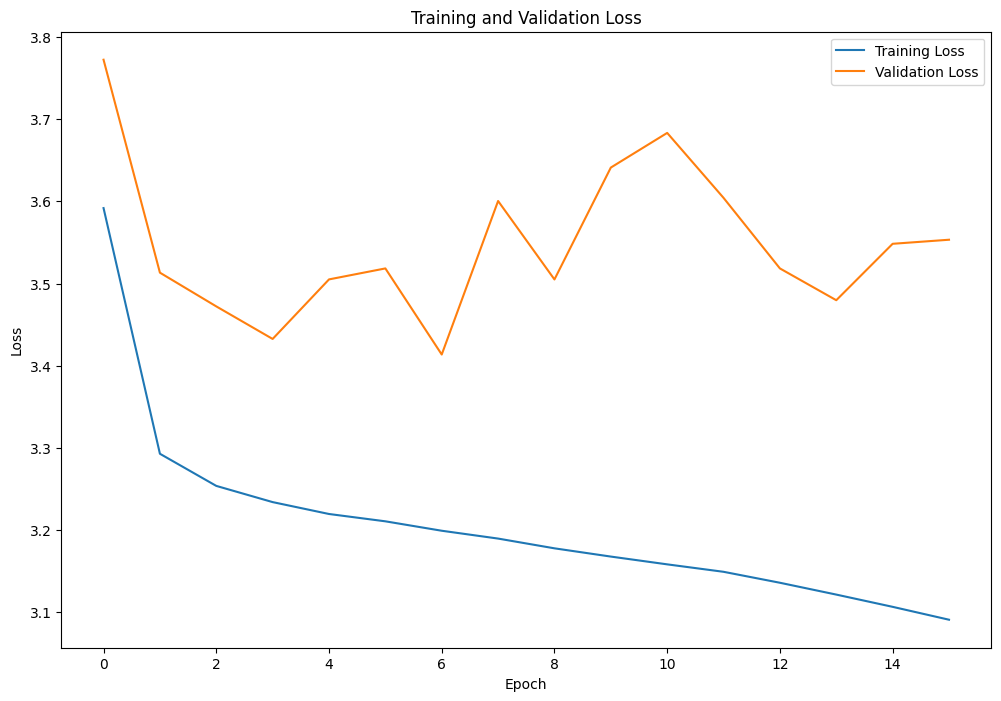

''

In [21]:
fig, ax = plt.subplots(figsize=(12, 8))

# Plot training loss
ax.plot(loss_dict['train_losses'], label='Training Loss')

# Plot validation loss
ax.plot(loss_dict['val_losses'], label='Validation Loss')

ax.set_title('Training and Validation Loss')
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')
ax.legend()

plt.show()
,

In [76]:
import nltk
from nltk.translate.bleu_score import sentence_bleu

def compute_bleu(output, reference):
    output_tokens = tokenizer.decode(output, skip_special_tokens=True)
    reference_tokens = tokenizer.decode(reference, skip_special_tokens=True)
    reference_words = nltk.word_tokenize(reference_tokens)
    output_words = nltk.word_tokenize(output_tokens)

    # Compute BLEU score
    bleu_score = sentence_bleu([reference_words], output_words)
    return bleu_score

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [90]:
poems = [
    'میازار موری که داته کش است',
    'که اخذ کرد او دیپ با فاطمی',
    'چون سنگها صدای مرا گوش می کنی',
    'از دام بوسه راه گریزی اگر که بود',
    'گل من را اذیت نکنین',
    'توانا بود هرکه دانا بود',
]

for poem in poems:
    gen_encoding = {'input_ids': 0, 'attention_mask': 0}
    input_ = tokenizer(
        [tokenizer.eos_token + poem + tokenizer.bos_token],
        truncation=True,
        padding="max_length",
        return_tensors='pt'
    )
    gen_encoding['input_ids'] = input_["input_ids"].to(device)
    gen_encoding['attention_mask'] = torch.ones_like(gen_encoding['input_ids']).to(device)
    gen = model.module if parallel else model
    outputs = gen.generate(
        **gen_encoding,
        top_k=50,
        max_length=24,
        num_beams=5,
        no_repeat_ngram_size=1,
        num_return_sequences=1,
        do_sample = False,
        pad_token_id=tokenizer.eos_token_id, # Open end generation
    )
    in_stanza = tokenizer.decode(gen_encoding['input_ids'][0], skip_special_tokens=True)
    out_stanza = tokenizer.decode(outputs[0], skip_special_tokens=True)
    out_stanza = out_stanza.replace(in_stanza, in_stanza + '  ,  ')
    print('Generated sequence: ')
    print(out_stanza)
    
    target_array = input_["input_ids"].cpu().numpy().flatten()
    output_array = outputs.cpu().numpy().flatten()
    bleu_score = compute_bleu(output_array, target_array)
    print(f'BLEU Score: {bleu_score:.4f}\n')

Generated sequence: 
میازار موری که داته کش است  ,   چند را و رویاراستازند
BLEU Score: 0.5170

Generated sequence: 
که اخذ کرد او دیپ با فاطمی  ,   چند ازش را دل برند هاشمی
BLEU Score: 0.4704

Generated sequence: 
چون سنگها صدای مرا گوش می کنی  ,   چند هاشمی بیوهاردانانند سفتگذاشتند
BLEU Score: 0.5707

Generated sequence: 
از دام بوسه راه گریزی اگر که بود  ,   چند بیوهست و چهر را ایشان بر
BLEU Score: 0.4759

Generated sequence: 
گل من را اذیت نکنین  ,   چند از نیشار نهانسا خدای
BLEU Score: 0.3928

Generated sequence: 
توانا بود هرکه دانا بود  ,  ار کار سوار هاشمی تختش گاهند
BLEU Score: 0.2627

